In [24]:
import sys, os

sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
from src import mhdx_engine, mhdx_extract_stats

In [26]:
indexes_folder = "../datasets/noise_arrays/"

In [27]:
fpath = indexes_folder + "Index_00001.pkl"

out1 = mhdx_extract_stats.load_noise_arrays(fpath)

In [28]:
fpath = indexes_folder + "Index_00002.pkl"

out2 = mhdx_extract_stats.load_noise_arrays(fpath)

In [29]:
fpath = indexes_folder + "Index_00003.pkl"

out3 = mhdx_extract_stats.load_noise_arrays(fpath)

In [30]:
# Define charge of tensor

charge = 6

In [31]:
engine1 = mhdx_engine.HDXTimecourseEngine(sequence=out1['sequence'],
                            timepoints=out1['timepoints'],
                            ks=out1['rates'],
                            backexchange=out1['backexchange'],
                            charge=charge,
                            rt_center=out1['rt'],
                            rt_mean=out1['rt'] + out1['rt_total_error_mean'],
                            rt_std=out1['rt_sigma_baseline'] + out2['rt_total_error_std'],
                            dt_center=out1['dt_mean_baseline'][charge],
                            dt_mean=out1['dt_mean_baseline'][charge] + out1['dt_total_error_mean'][charge],
                            dt_std=out1['dt_std_baseline'][charge] + out1['dt_total_error_std'][charge],
                            ppm_error=out1['ppm_errors'],
                            tics=out1['intensities'],
                            grid_step_mz=0.01,
                            )

In [32]:
engine2 = mhdx_engine.HDXTimecourseEngine(sequence=out2['sequence'],
                            timepoints=out2['timepoints'],
                            ks=out2['rates'],
                            backexchange=out2['backexchange'],
                            charge=charge,
                            rt_center=out2['rt'],
                            rt_mean=out2['rt'] + out2['rt_total_error_mean'],
                            rt_std=out2['rt_sigma_baseline'] + out3['rt_total_error_std'],
                            dt_center=out2['dt_mean_baseline'][charge],
                            dt_mean=out2['dt_mean_baseline'][charge] + out2['dt_total_error_mean'][charge],
                            dt_std=out2['dt_std_baseline'][charge] + out2['dt_total_error_std'][charge],
                            ppm_error=out2['ppm_errors'],
                            tics=out2['intensities'],
                            grid_step_mz=0.01,
                            )

In [33]:
engine3 = mhdx_engine.HDXTimecourseEngine(sequence=out3['sequence'],
                            timepoints=out3['timepoints'],
                            ks=out3['rates'],
                            backexchange=out3['backexchange'],
                            charge=charge,
                            rt_center=out3['rt'],
                            rt_mean=out3['rt'] + out3['rt_total_error_mean'],
                            rt_std=out3['rt_sigma_baseline'] + out3['rt_total_error_std'],
                            dt_center=out3['dt_mean_baseline'][charge],
                            dt_mean=out3['dt_mean_baseline'][charge] + out3['dt_total_error_mean'][charge],
                            dt_std=out3['dt_std_baseline'][charge] + out3['dt_total_error_std'][charge],
                            ppm_error=out3['ppm_errors'],
                            tics=out3['intensities'],
                            grid_step_mz=0.01,
                            )

In [34]:
engine1.generate_ideal_tensor()
engine1.apply_perturbations()
engine1.add_random_noise(high=50)


engine2.generate_ideal_tensor()
engine2.apply_perturbations()
engine2.add_random_noise(high=50)

engine3.generate_ideal_tensor()
engine3.apply_perturbations()
engine3.add_random_noise(high=50)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, to_rgba

def plot_tensor(
    engine,
    tensor: np.ndarray,
    *,
    color: str = "C0",
    scale_with: list[np.ndarray] | None = None,
    global_mz_max: float | None = None,
    save_path: str | None = None,
    dpi: int = 300,
    figsize_scale: float = 1.4,
    heatmap_vmax: float | None = None,  # set to a number to lock heatmap scale
):
    """
    Plot per-timepoint: (left) m/z marginal; (right) RT×DT heatmap.

    Parameters
    ----------
    engine : object with .mz_labels, .rt_labels, .dt_labels
    tensor : (T,R,D,M) ndarray
    color : str
        Base color for both line plot and heatmap.
    scale_with : list of (T,R,D,M) ndarrays or None
        If provided, the left-panel y-axis max is the max across [tensor]+scale_with.
    global_mz_max : float or None
        If provided, use this exact max for left-panel y-axis.
        Overrides `scale_with`.
    save_path : str or None
        If provided, saves the figure. Extension determines format (e.g., .pdf, .png).
    dpi : int
    figsize_scale : float
        Vertical scaling factor for figure height.
    heatmap_vmax : float or None
        If not None, use as vmax for heatmap color scaling (keeps scale consistent).
    """
    def _three_ticks(n: int):
        # start, middle, end (unique & sorted)
        return sorted(set([0, n // 2, n - 1]))

    def _cmap_from_color(col: str) -> LinearSegmentedColormap:
        # White -> color gradient so the chosen color defines the heatmap
        return LinearSegmentedColormap.from_list("mono_" + col, ["#ffffff", col])

    # ---------- compute global y max for m/z marginal ----------
    def _mz_max(t: np.ndarray) -> float:
        # maximum of the marginal over m/z (sum over RT,DT), per timepoint; then across timepoints
        # but for axis limit we want a single scalar max across all timepoints
        return float(np.max(np.sum(t, axis=(1, 2), dtype=float)))

    if global_mz_max is not None:
        y_max = float(global_mz_max)
    else:
        tensors_for_scaling = [tensor] + (list(scale_with) if scale_with else [])
        y_max = max(_mz_max(t) for t in tensors_for_scaling if t is not None)
    if not np.isfinite(y_max) or y_max <= 0:
        y_max = 1.0
    y_max *= 1.05  # small headroom

    # ---------- figure/axes ----------
    T = tensor.shape[0]
    fig, axes = plt.subplots(
        T, 2, figsize=(6, T * figsize_scale), dpi=dpi, constrained_layout=True,
        width_ratios=[3, 1]
    )
    axes = np.atleast_2d(axes)  # makes (T,2) even when T==1

    # ---------- shared styles ----------
    line_c = color
    cmap = _cmap_from_color(color)

    for i, t_slice in enumerate(tensor):
        # ===== Left: m/z marginal =====
        mz_profile = t_slice.sum(axis=(0, 1))  # (M,)
        ax0 = axes[i, 0]
        ax0.plot(engine.mz_labels, mz_profile, lw=0.8, color=line_c)
        ax0.set_xlabel("m/z", fontsize=8)
        ax0.set_ylabel("Intensity (a.u.)", fontsize=8)

        # axis style & ticks
        ax0.tick_params(axis='both', which='both', labelsize=8, top=False, left=True)
        ax0.spines['top'].set_visible(False)
        ax0.spines['right'].set_visible(False)
        # scientific notation on y
        ax0.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        # set global y max
        ax0.set_ylim(top=y_max)

        # ===== Right: RT×DT heatmap (sum over m/z) =====
        rd = t_slice.sum(axis=-1)  # shape (R, D)
        ax1 = axes[i, 1]
        sns.heatmap(
            rd, cmap=cmap, ax=ax1, cbar=False,
            vmin=0.0, vmax=heatmap_vmax  # lock vmax if provided
        )

        # build sparse ticks using labels: y=RT (min), x=DT (ms)
        R, D = rd.shape
        xt = _three_ticks(D)
        yt = _three_ticks(R)

        # heatmap cells are centered at i+0.5
        ax1.set_xticks(np.array(xt) + 0.5)
        ax1.set_yticks(np.array(yt) + 0.5)

        ax1.set_xticklabels([f"{engine.dt_labels[j]:.3f}" for j in xt], fontsize=8, rotation=0)
        ax1.set_yticklabels([f"{engine.rt_labels[j]:.2f}" for j in yt], fontsize=8, rotation=0)

        ax1.set_xlabel("DT (ms)", fontsize=8)
        ax1.set_ylabel("RT (min)", fontsize=8)

        ax1.tick_params(axis='both', which='both', labelsize=8, top=False, left=True)
        ax1.spines['top'].set_visible(False)
        ax1.spines['left'].set_visible(False)

    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=dpi)

    return fig, axes, y_max

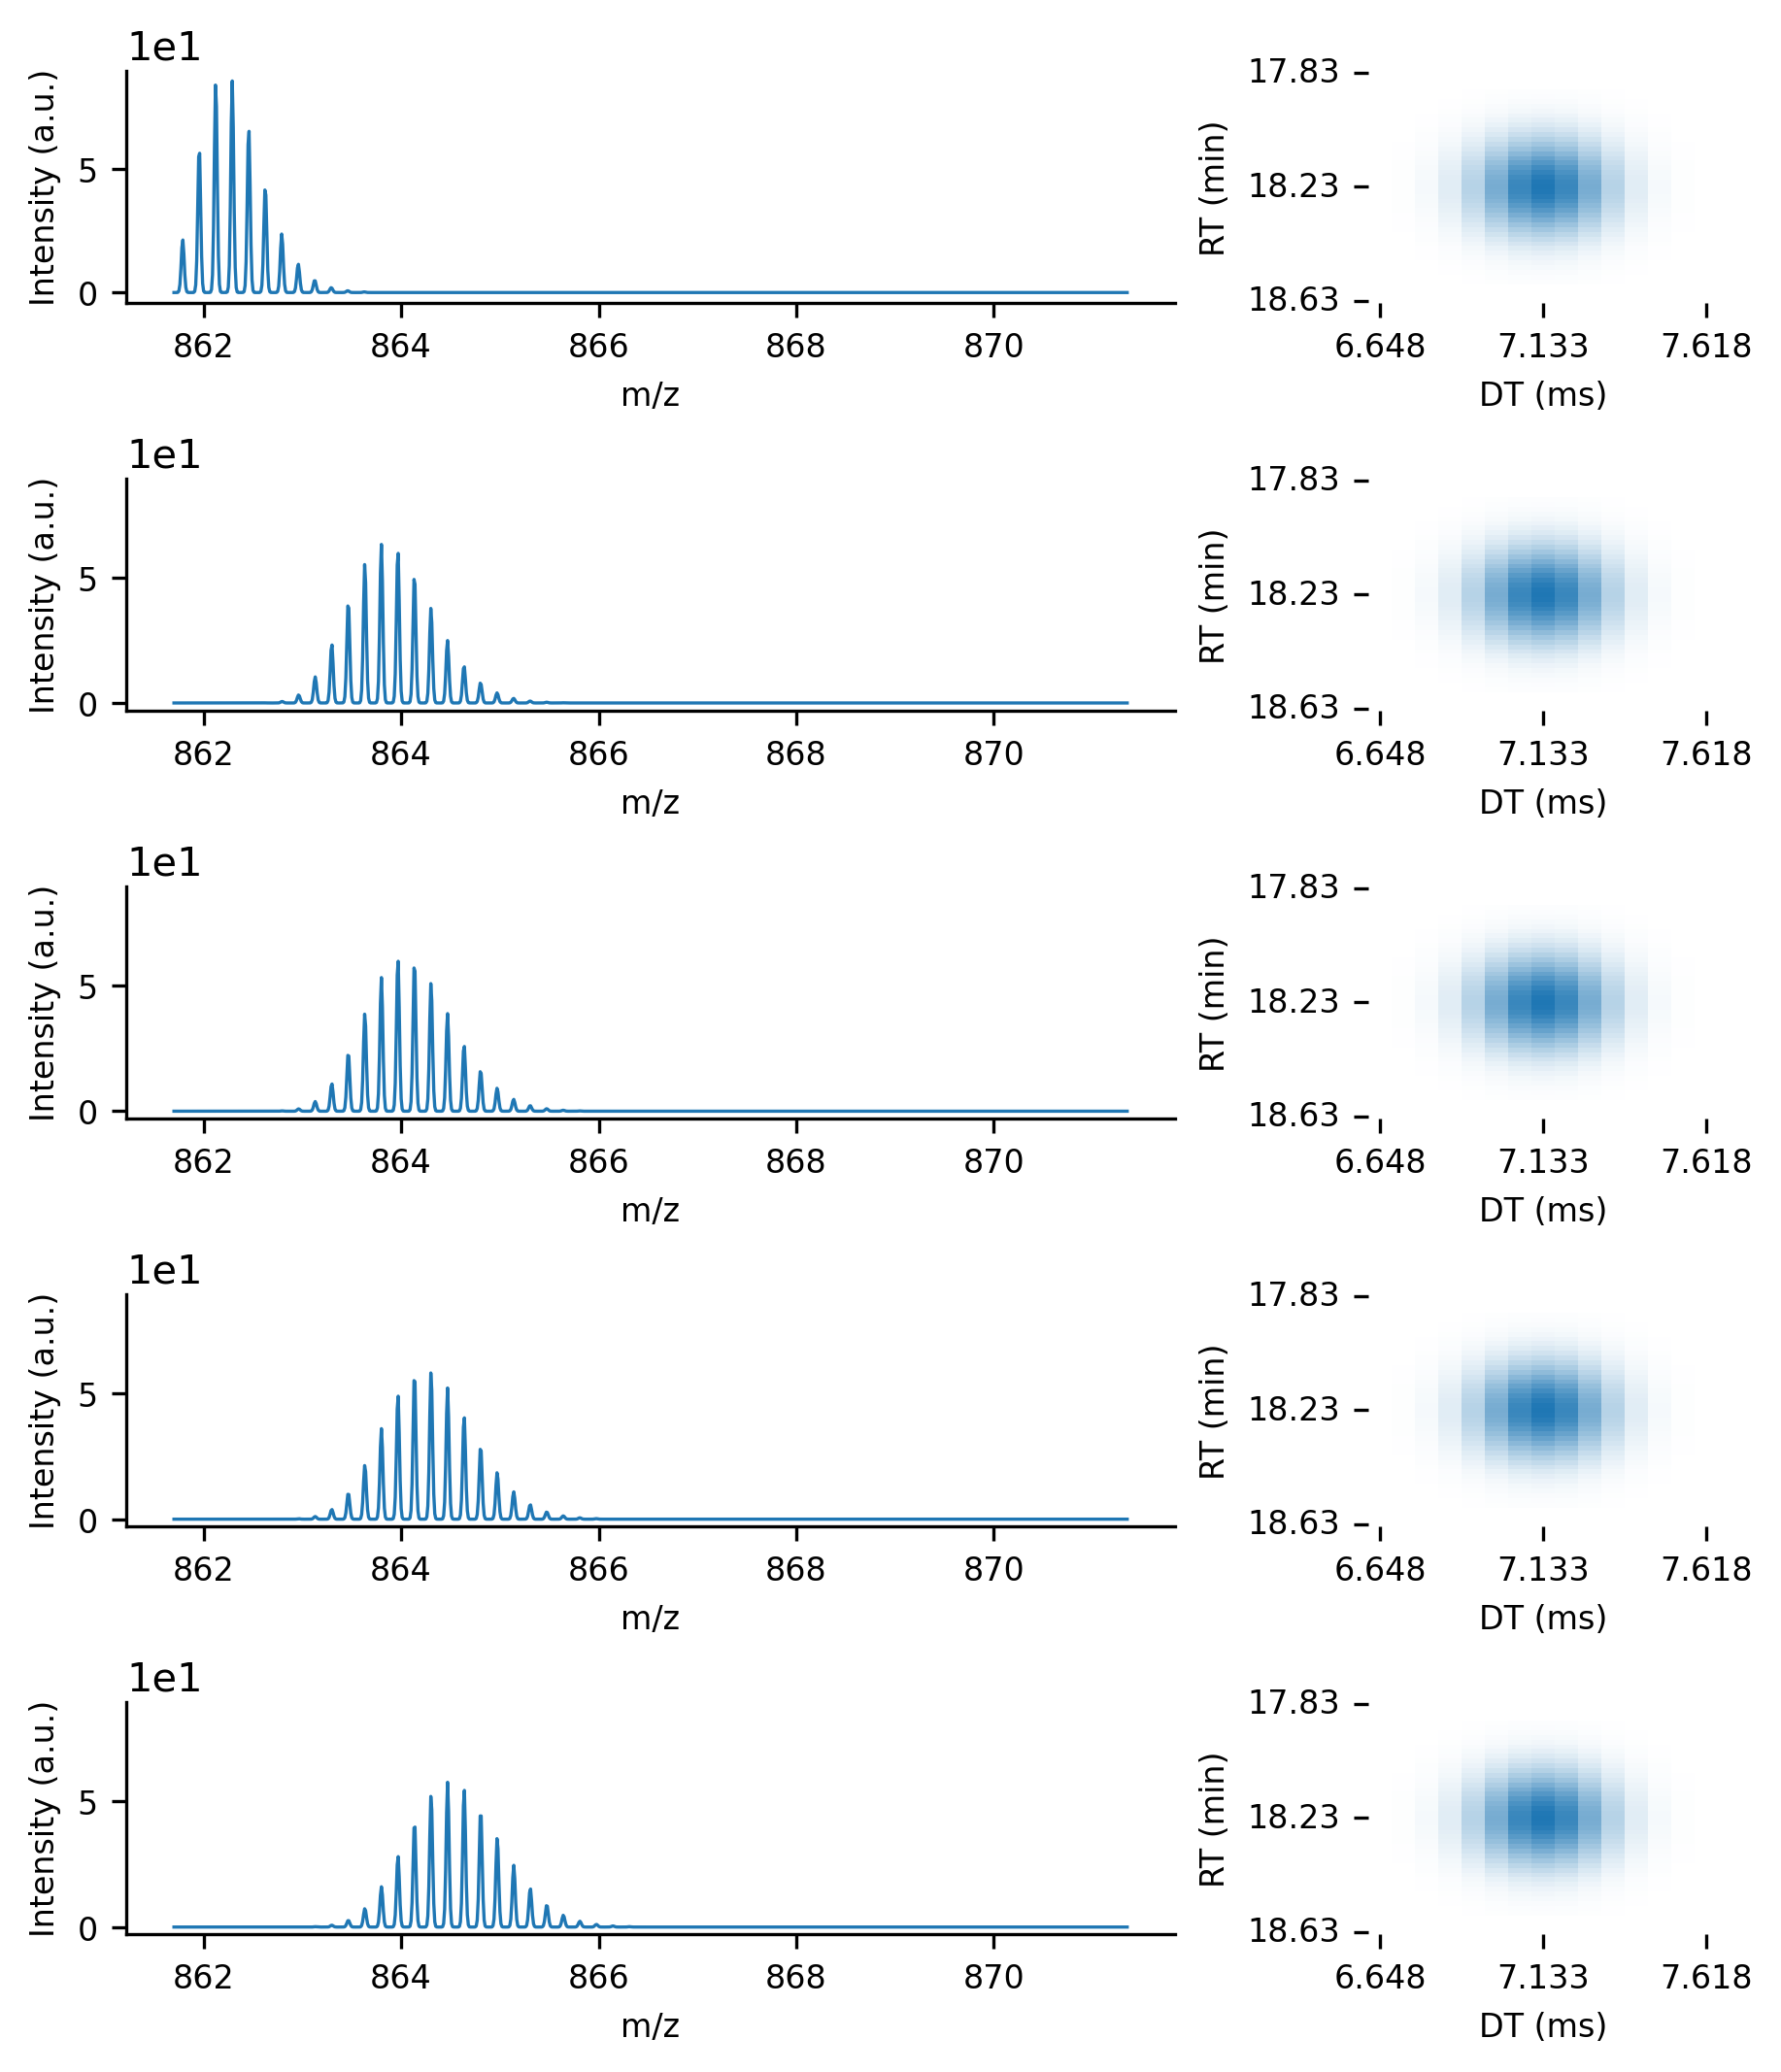

In [36]:
fig, axes, y_max = plot_tensor(engine1, engine1.ideal_tensor[:5], save_path="../datasets/figs/engine1.ideal.png" )

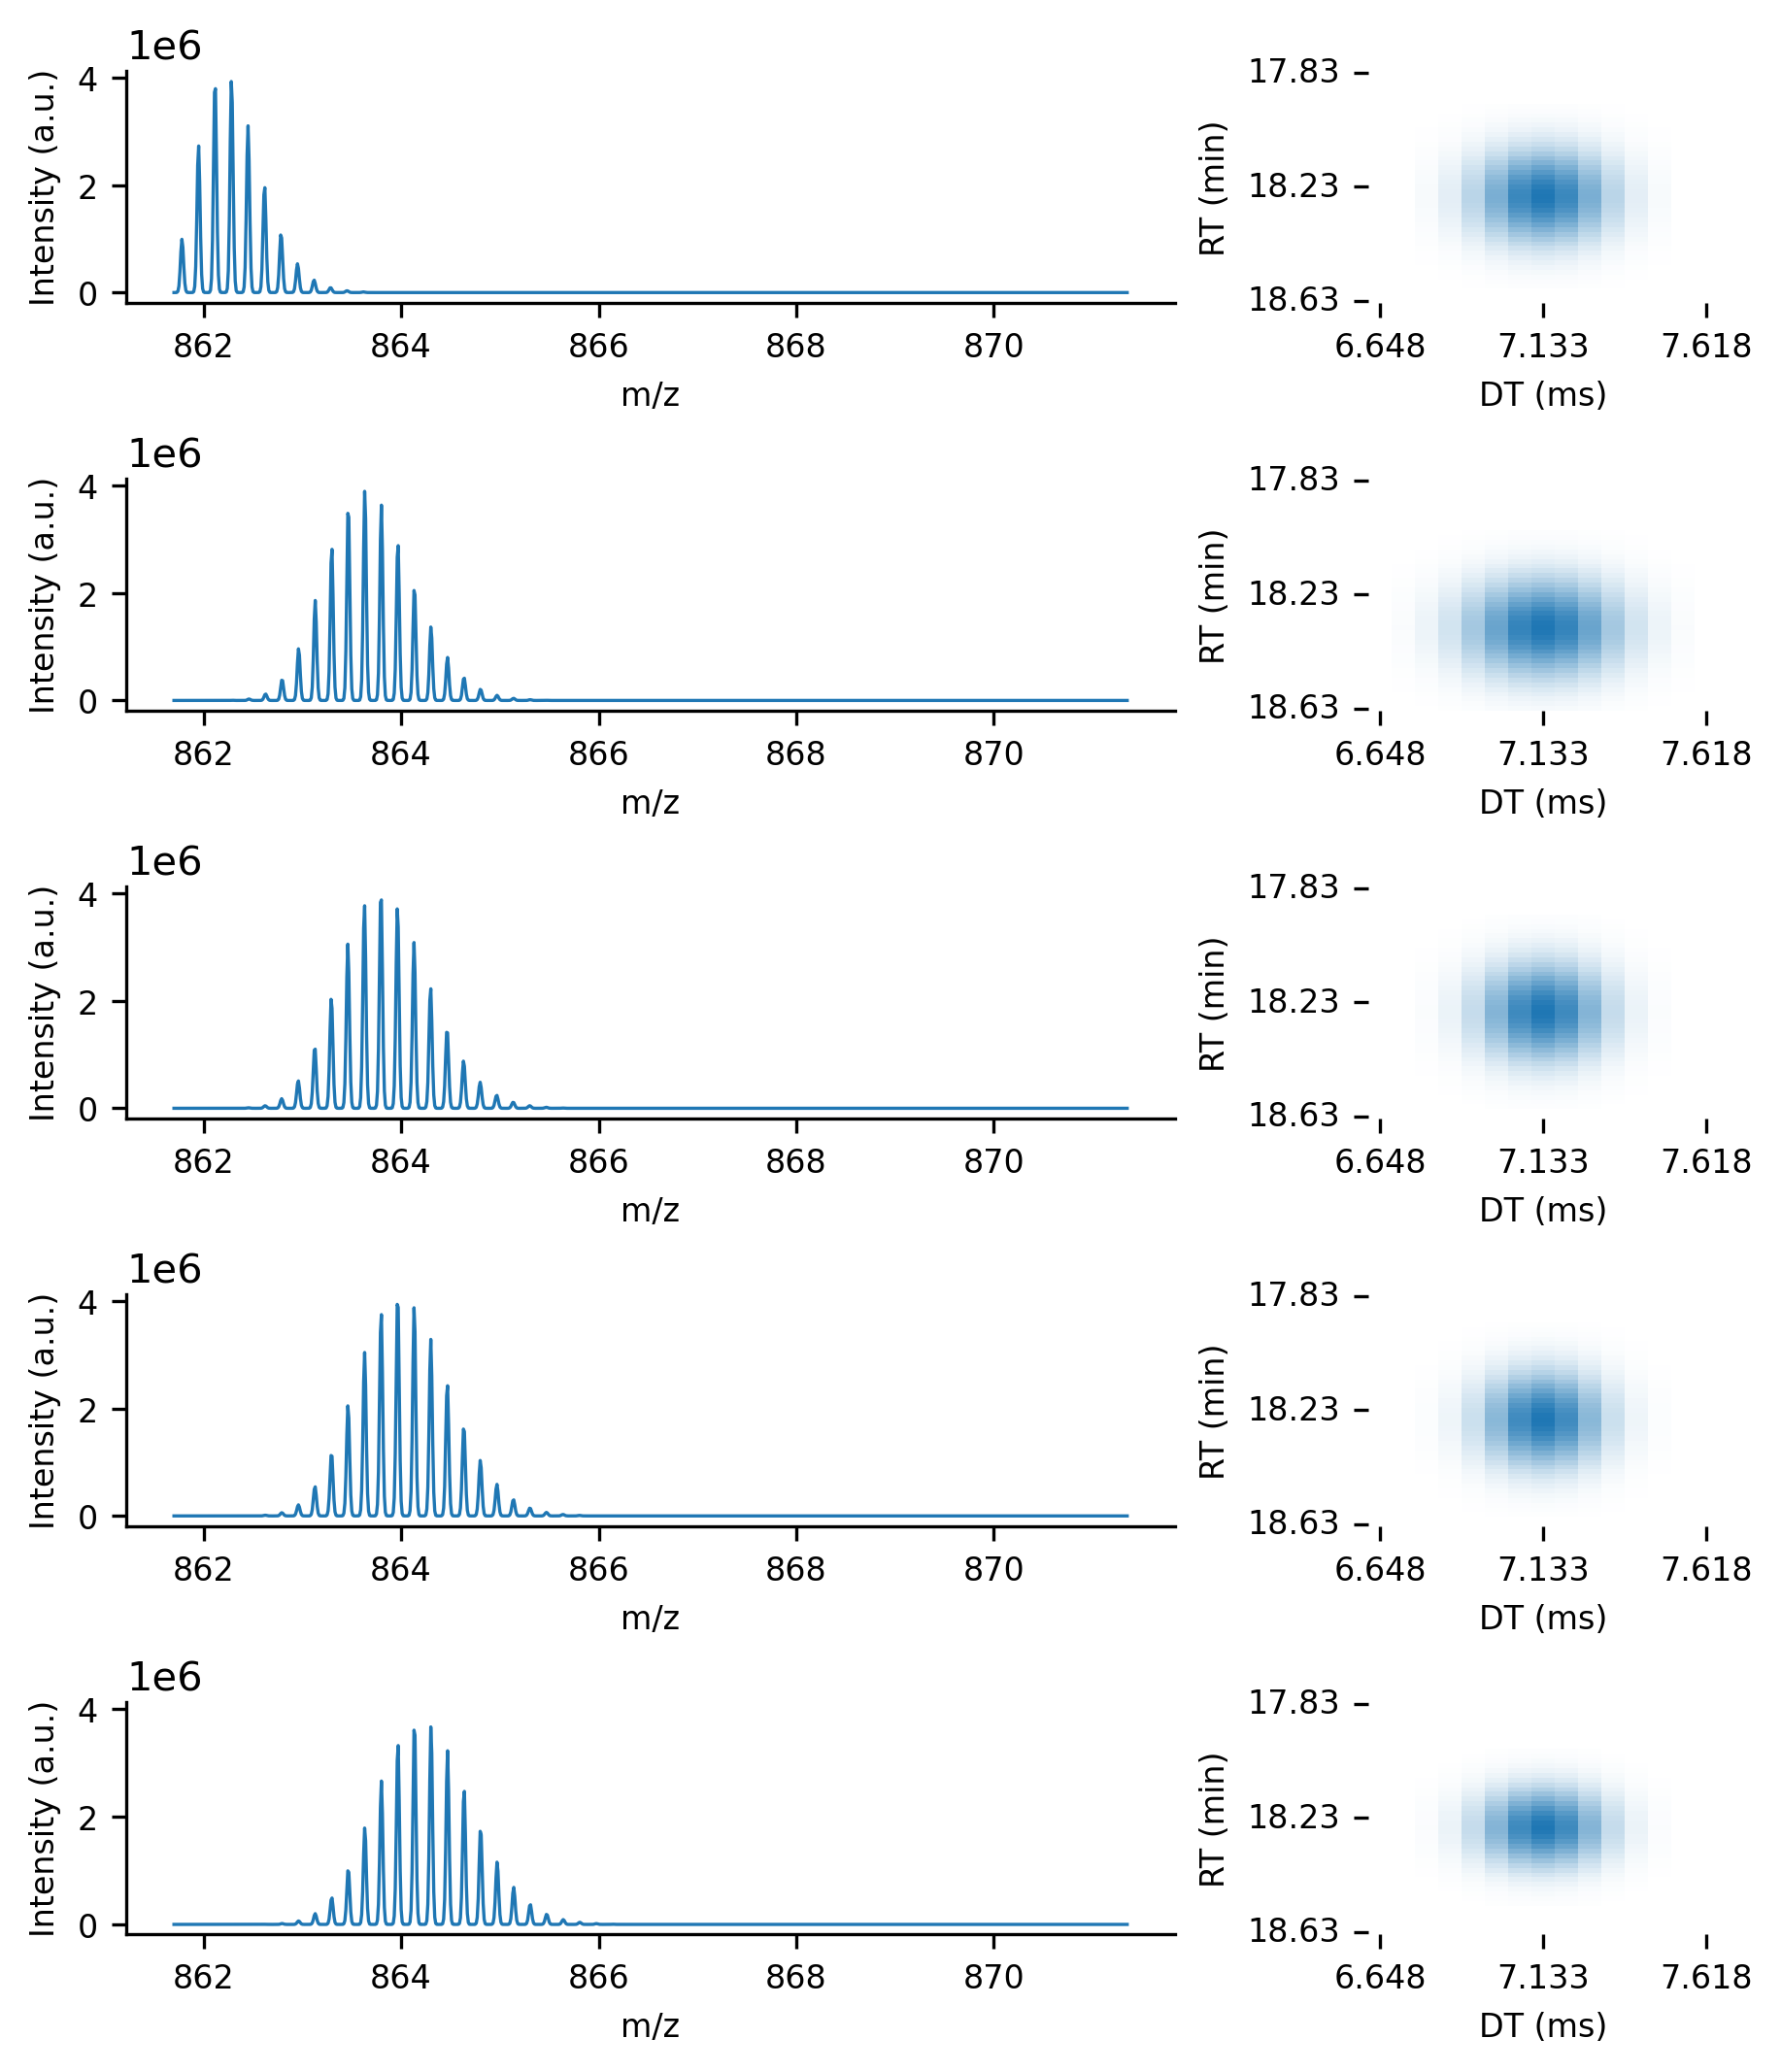

In [37]:
fig, axes, y_max = plot_tensor(engine1, engine1.perturbed_tensor[:5], save_path="../datasets/figs/engine1.perturbed.png")

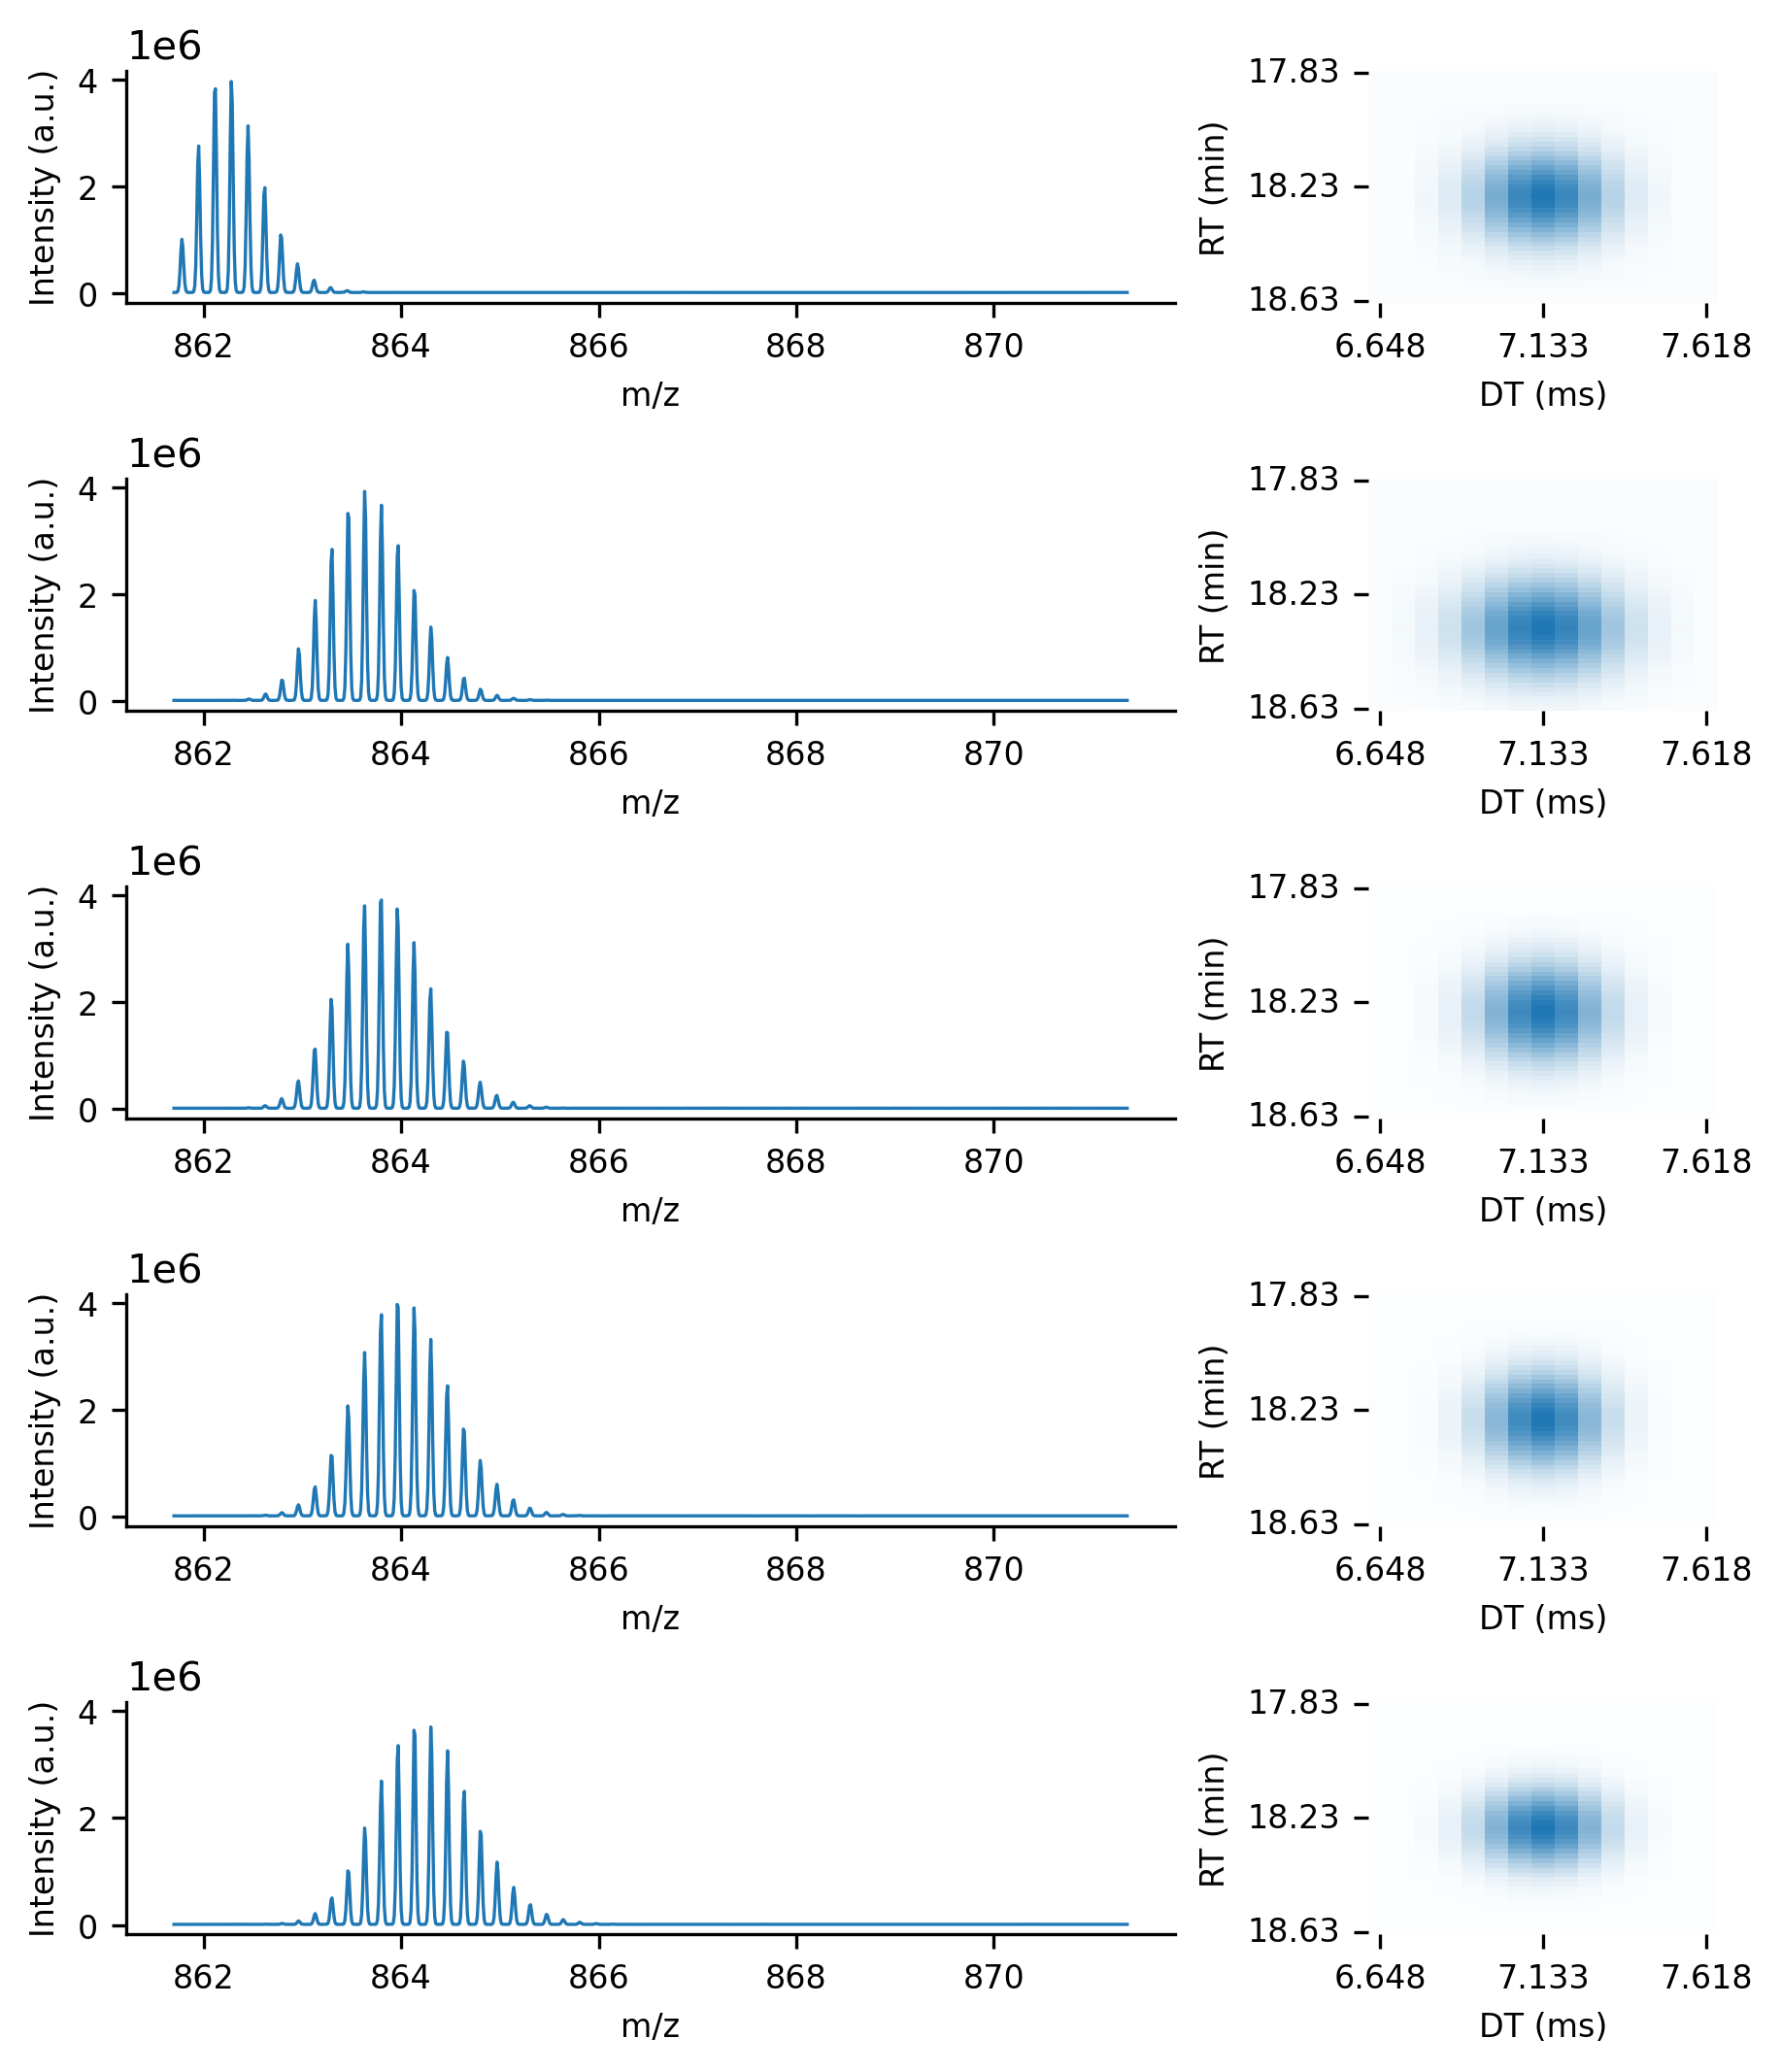

In [38]:
fig, axes, y_max = plot_tensor(engine1, engine1.noisy_tensor[:5], save_path="../datasets/figs/engine1.noisy.png")

In [126]:
# Save single tensors

In [13]:
output_dir = '../datasets/single_tensors'

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [14]:
output_path = output_dir + "/" + "Index_0001.npz"

engine1.save_npz(output_path)

In [15]:
output_path = output_dir + "/" + "Index_0002.npz"

engine2.save_npz(output_path)

In [16]:
output_path = output_dir + "/" + "Index_0003.npz"

engine3.save_npz(output_path)

In [23]:
# Checking if save/load npz works fine

In [18]:
from src import io

In [20]:
lt = io.load_engine_tensor_npz("../datasets/single_tensors/Index_0001.npz")

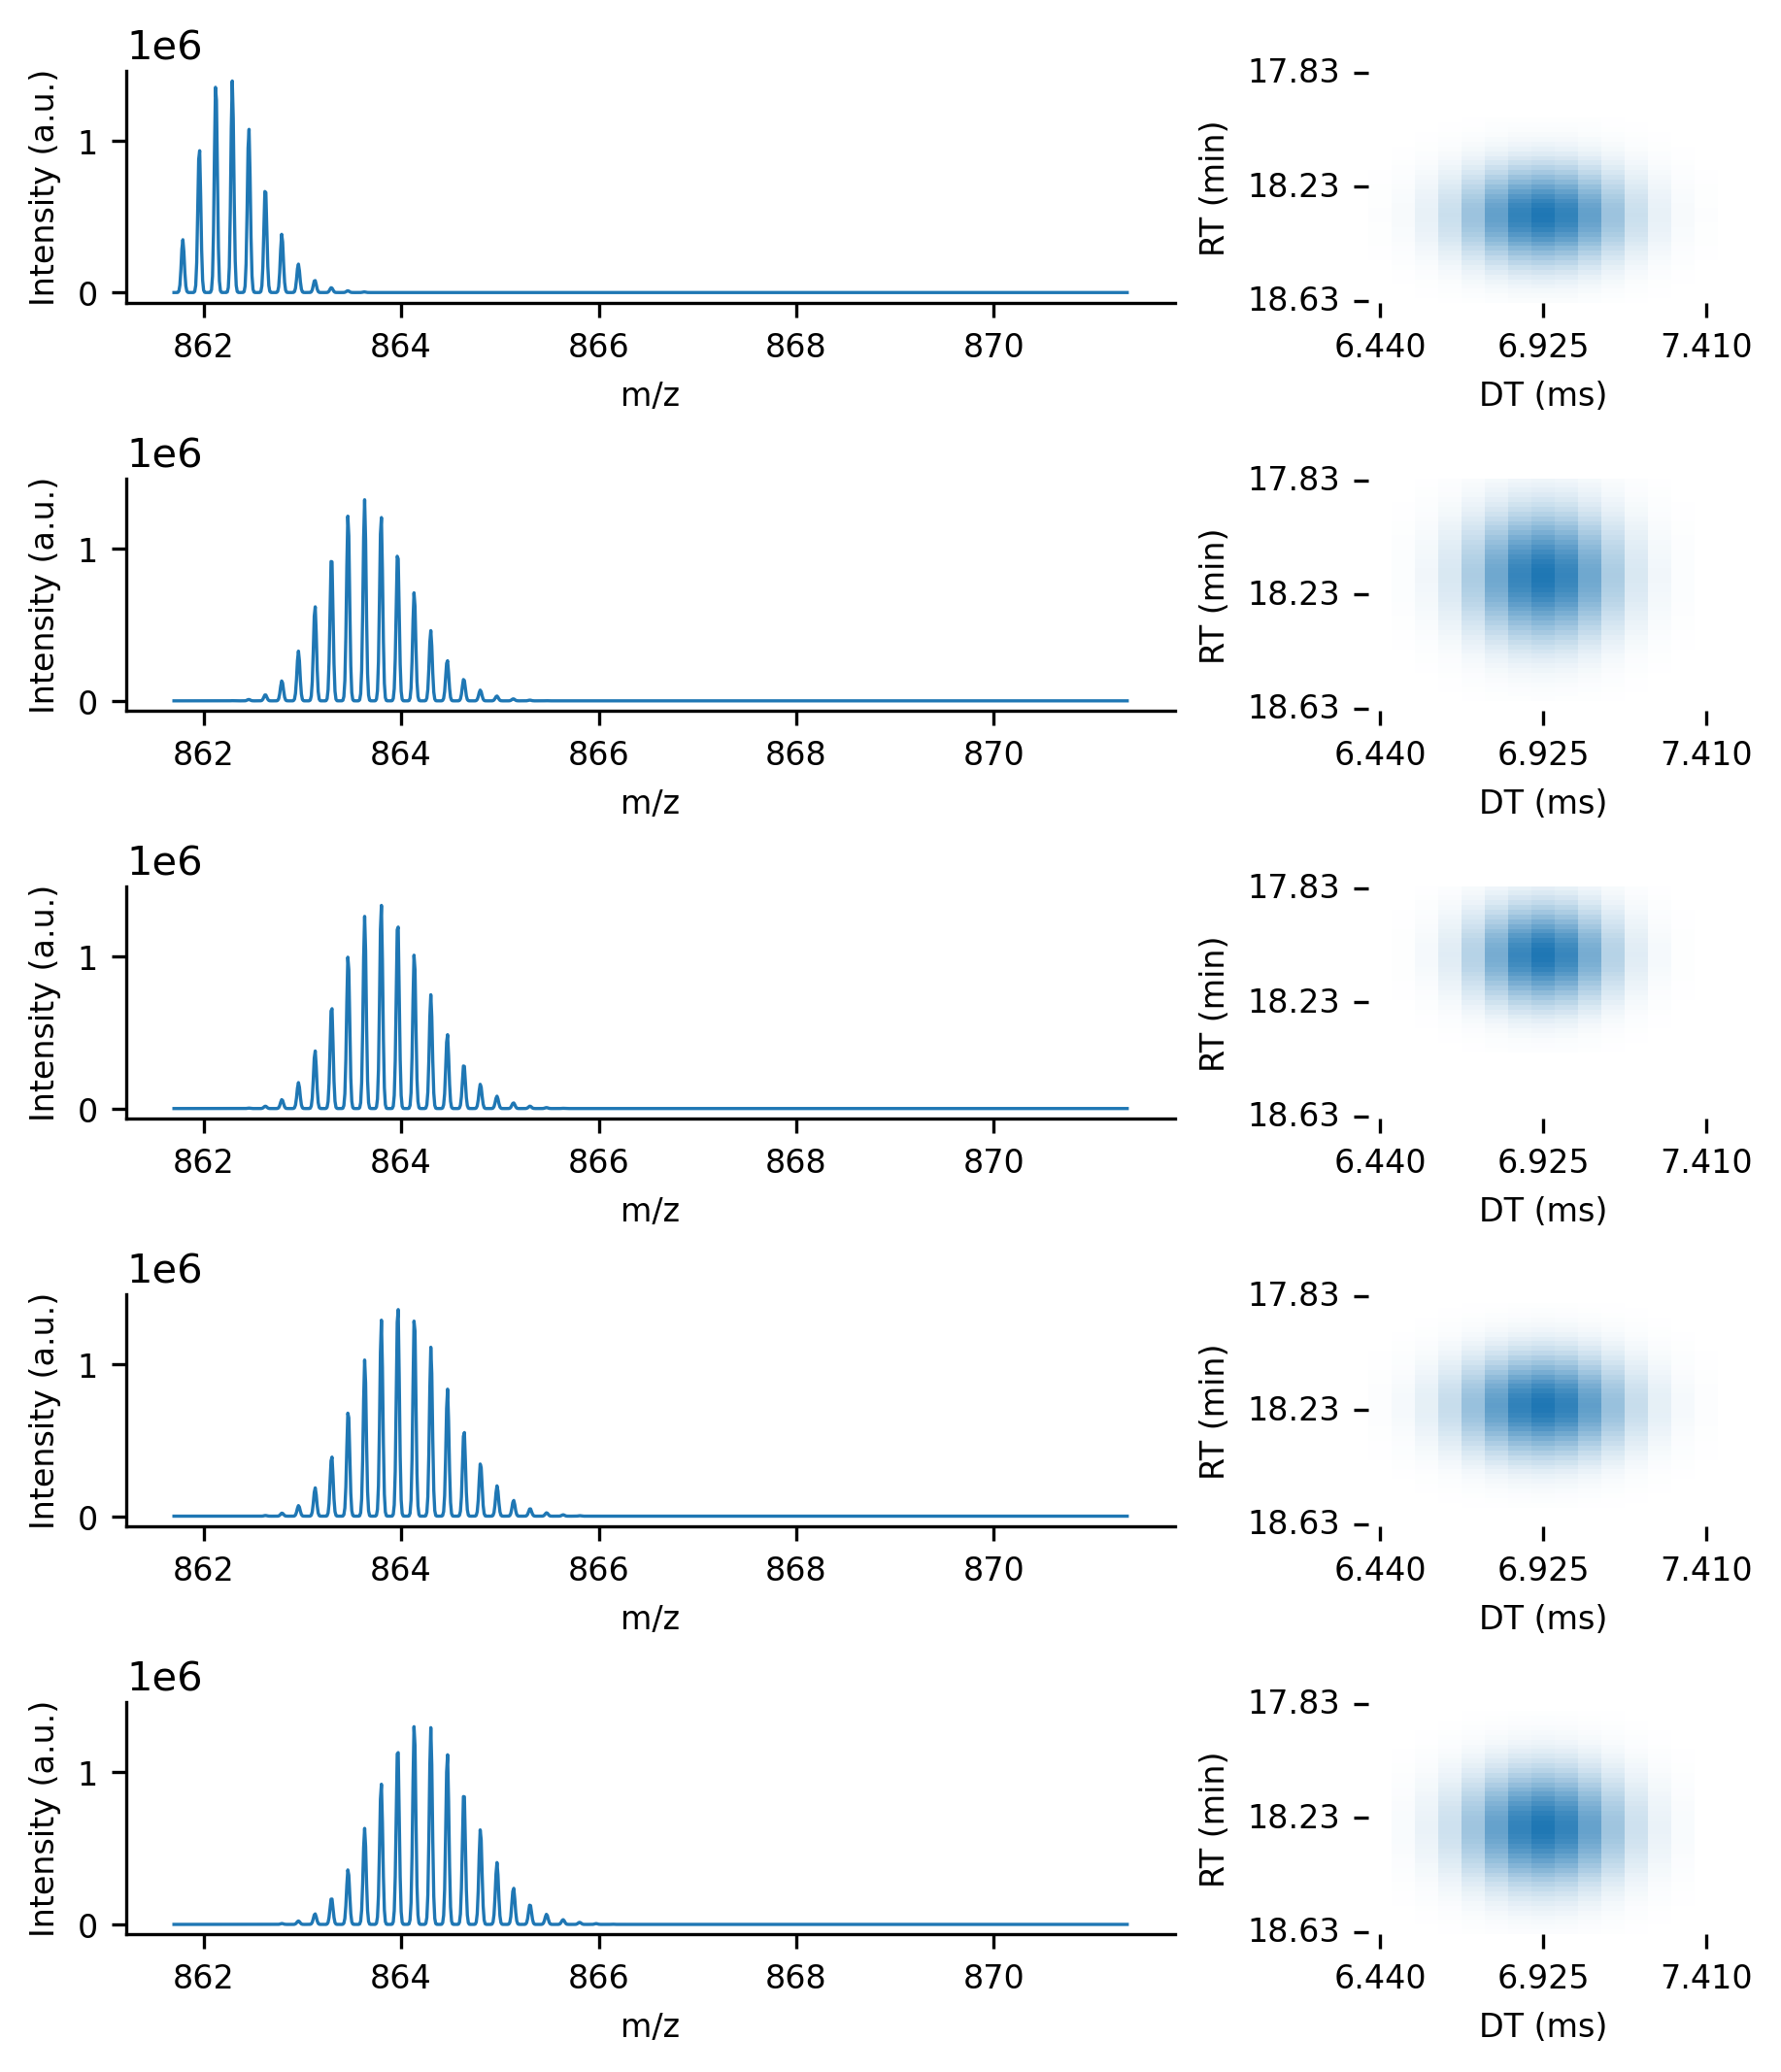

In [22]:
# Use axes for plotting/combining
fig, axes, y_max = plot_tensor(lt, lt.tensor[:5])  # if your plotter expects engine-like, pass lt attributes